Import Libraries

In [1]:
import csv
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm

import nltk

nltk.download('all')

import re

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

Load the dataset and remove invalid data

In [2]:
raw_data = pd.read_csv('categories.csv', sep = ';', header = None)

In [3]:
raw_data.columns = ["Text", "Class"]

In [4]:
raw_data = raw_data.dropna()
raw_data.head(10)

,Text,Class
0,i feel lots of crypto has exhausted itself,1.0
1,How are you guys feeling today ??? :Bear: or ...,1.0
2,Did not take a trade today,1.0
3,Just entered eos long trade 👌,1.0
4,Anything good to buy now? Or did I miss it 😭,1.0
5,GL trading tonight guys. I'm off to eat dinne...,1.0
6,Okay my long position is still open on eth,1.0
7,morning guys any trades avaiable?,1.0
8,What’s everybodies thoughts today?,1.0
9,Are you guys more bullish or bearish for this ...,1.0


<Axes: >

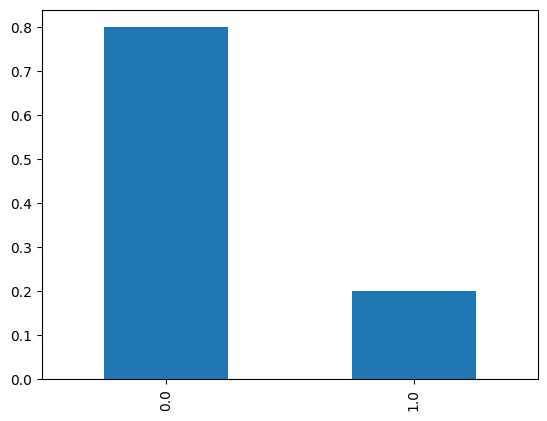

In [5]:
raw_data['Class'].value_counts(normalize = True).plot.bar()

Check the dataset

In [6]:
class_1_data = raw_data[raw_data["Class"] == 1]
class_0_data = raw_data[raw_data["Class"] == 0]

In [7]:
print("Samples of Class 0 : ", len(class_0_data.index))
print("Samples of Class 1 : ", len(class_1_data.index))

Samples of Class 0 :  23099
Samples of Class 1 :  5762


all sentences belonging to class 1 + randomly selected the same amount of sentences belonging to class 0

In [8]:
balanced_dataset = pd.concat([class_1_data, class_0_data.sample(len(class_1_data.index))], ignore_index=True)

In [9]:
print("Samples of Balanced Dataset : ", len(balanced_dataset.index))

Samples of Balanced Dataset :  11524


text pre-processing

In [10]:
text_list = list(balanced_dataset['Text'])
class_list = list(balanced_dataset['Class'])

In [11]:
def preprocessing(text_list, class_list):
  corpus = []
  classes = []
  for i in range(len(text_list)):
    try:
      r = re.sub('[^a-zA-Z]', ' ', text_list[i])
      r = r.lower()
      r = r.split()
      r = [word for word in r if word not in stopwords.words('english')]
      r = [lemmatizer.lemmatize(word) for word in r]
      r = ' '.join(r)
      corpus.append(r)
      classes.append(int(class_list[i]))
    except:
      print(text_list[i])
  return corpus, classes

In [12]:
corpus, classes = preprocessing(text_list, class_list)

Split the data into train and test sets

In [13]:
X = corpus
y = classes

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Convert text data into numerical features using TF-IDF

In [16]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# **XGBoost Model**

- Train the XGBoost model

In [17]:
xgb_classifier = xgb.XGBClassifier(n_jobs=-1)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

- Save the model

In [18]:
with open('xgboost_model.pkl','wb') as f:
    pickle.dump(xgb_classifier,f)

- Load the model

In [19]:
with open('xgboost_model.pkl', 'rb') as f:
    clf = pickle.load(f)

- Make predictions on the test set

In [20]:
predictions = clf.predict(X_test)

- Evaluate the model performance(Cofusion Matrix, Accuracy, Precision, Recall, F1-Score)

In [21]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 94.97%


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       576
           1       0.96      0.94      0.95       577

    accuracy                           0.95      1153
   macro avg       0.95      0.95      0.95      1153
weighted avg       0.95      0.95      0.95      1153



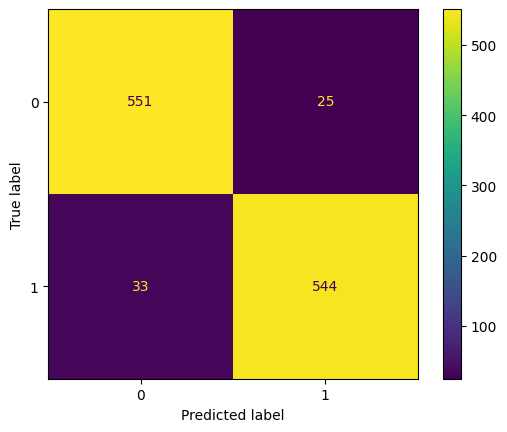

In [22]:
# Create the confusion matrix
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(classification_report(y_test,predictions))

# **SVM Classifier**

- Train the SVM model

In [23]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train, y_train)

SVC(gamma='auto', kernel='linear')

- Save the model

In [24]:
with open('svm_model.pkl','wb') as f:
    pickle.dump(SVM,f)

- Load the model

In [25]:
with open('svm_model.pkl', 'rb') as f:
    clf = pickle.load(f)

- Make predictions on the test set

In [ ]:
predictions = clf.predict(X_test)

- Evaluate the model performance(Cofusion Matrix, Accuracy, Precision, Recall, F1-Score)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 93.58%


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       576
           1       0.94      0.94      0.94       577

    accuracy                           0.94      1153
   macro avg       0.94      0.94      0.94      1153
weighted avg       0.94      0.94      0.94      1153



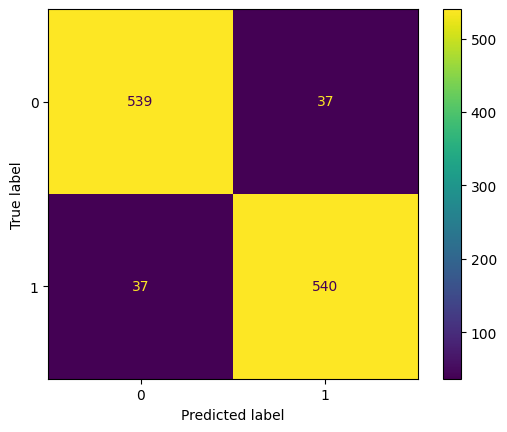

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(classification_report(y_test,predictions))

# **Random Forests**

- Train the SVM model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

- Save the model

In [ ]:
with open('rf_model.pkl','wb') as f:
    pickle.dump(rf,f)

- Load the model

In [ ]:
with open('rf_model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [ ]:
predictions = clf.predict(X_test)

- Evaluate the model performance(Cofusion Matrix, Accuracy, Precision, Recall, F1-Score)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 94.36%


              precision    recall  f1-score   support

           0       0.95      0.94      0.94       576
           1       0.94      0.95      0.94       577

    accuracy                           0.94      1153
   macro avg       0.94      0.94      0.94      1153
weighted avg       0.94      0.94      0.94      1153



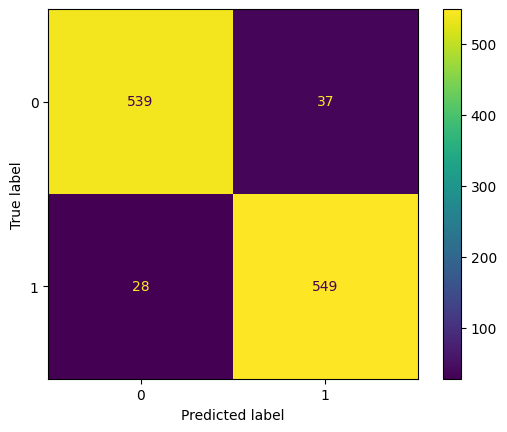

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(classification_report(y_test,predictions))

# **Non-linear SVM**

In [ ]:
nu_svm = svm.NuSVC(gamma="auto")
nu_svm.fit(X_train, y_train)

NuSVC(gamma='auto')

- Save the model

In [ ]:
with open('nu_svm_model.pkl','wb') as f:
    pickle.dump(nu_svm,f)

- Load the model

In [ ]:
with open('nu_svm_model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [ ]:
predictions = clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 89.51%


              precision    recall  f1-score   support

           0       0.85      0.96      0.90       576
           1       0.95      0.83      0.89       577

    accuracy                           0.90      1153
   macro avg       0.90      0.90      0.89      1153
weighted avg       0.90      0.90      0.89      1153



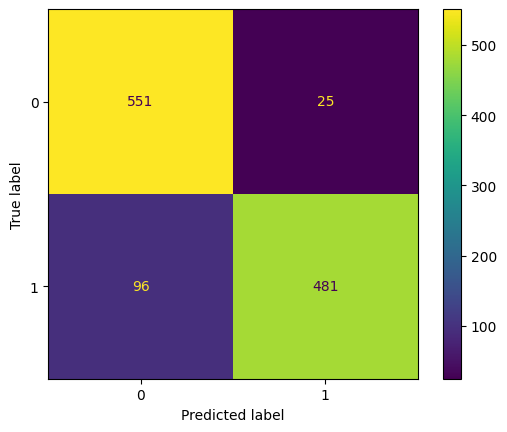

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(classification_report(y_test,predictions))

# **MLPClassifier**

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

- Save the model

In [ ]:
with open('MLP_model.pkl','wb') as f:
    pickle.dump(clf,f)

- Load the model

In [ ]:
with open('MLP_model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [ ]:
predictions = clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 93.84%


              precision    recall  f1-score   support

           0       0.95      0.93      0.94       576
           1       0.93      0.95      0.94       577

    accuracy                           0.94      1153
   macro avg       0.94      0.94      0.94      1153
weighted avg       0.94      0.94      0.94      1153



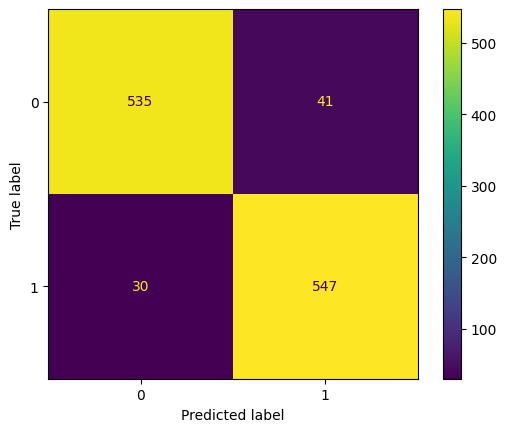

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(classification_report(y_test,predictions))

# **How to predict the label for input text**

In [ ]:
new_input = ["What’s everybodies thoughts today?", "Anything good to buy now? Or did I miss it "]


In [ ]:
def process_input(text_list):
  corpus = []
  for i in range(len(text_list)):
    try:
      r = re.sub('[^a-zA-Z]', ' ', text_list[i])
      r = r.lower()
      r = r.split()
      r = [word for word in r if word not in stopwords.words('english')]
      r = [lemmatizer.lemmatize(word) for word in r]
      r = ' '.join(r)
      corpus.append(r)
    except:
      print(text_list[i])
  return corpus

- preprocessing

In [ ]:
input = process_input(new_input)
input

['everybodies thought today', 'anything good buy miss']

- Transfrom the text data into vector format

In [ ]:
input = vectorizer.transform(input)

- Load the model

In [ ]:
with open('MLP_model.pkl', 'rb') as f:
    clf = pickle.load(f)

In [ ]:
prediction = clf.predict(input)

In [ ]:
print(prediction)

[1 1]
